In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/17-category-flowers/17flowers.tgz


# Imports and Setting

First I import all the libraries required and also fix other settings.

In [2]:
import cv2
import os
import tensorflow as tf
import tarfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# turning off warning throughout the notebook
import warnings
warnings.filterwarnings('ignore')


In [3]:
# importing VGG-16 pre-trained model via Keras and also other dependencies
from keras.applications import VGG16
from keras import layers
from keras import optimizers
from keras import models
from keras.preprocessing.image import ImageDataGenerator

# Data Preparation

To access the raw data, upload raw data (i.e. 17flowers.tgz) to '/kaggle/input/17-category-flowers/'. The code below unzips the files and stores the flower images in jpg folder in the working directory. 

In [4]:
# os.getcwd() 
tar = tarfile.open('/kaggle/input/17-category-flowers/17flowers.tgz','r')
tar.extractall()

In [5]:
# the flowers in the dataset are in the order written in the classes list below. However, for classification,
# I replaced then with whole numbers from 0-16. 
# classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
#            'Crocus', 'Iris', 'Tigerlily', 'Tulip',
#            'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
#             'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
#             'Pansy']

classes = [ i for i in range(0,17) ]
y = np.repeat(classes, 80)
# one-hot encoding the 17 categories
y = tf.keras.utils.to_categorical(y, num_classes=17, dtype='float32')

In the cell below I load the images and store it in numpy array 'images'. I make the size of all images uniform (i.e. 224x224 pixels) with the help of dsize=(224,224).

In [6]:
images = []
loc = os.path.expanduser('/kaggle/working/jpg')

for filename in sorted(os.listdir(loc)):
    
    img = cv2.imread(os.path.join(loc,filename))    
    
    if img is not None:
        img = cv2.resize(img, dsize=(224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

images = np.asarray(images)


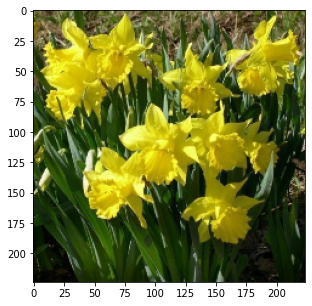

In [7]:
# plotting one random image to see if data loaded correctly.
plt.figure(figsize = (5,5))
plt.imshow(images[79])

In [8]:
# there are 1360 (i.e. 17*80) images in total, each with 224x224 pixels and 3 colour channels
images.shape

(1360, 224, 224, 3)

# CNN-Model Building 

I use convolution neural networks to build the classifier. I used transfer learning concepts to speed up the training process and get increased accuracy for the small input size (only 80 images per class). I used VGG16 pre trained model and built a classifier layer on top of it. VGG16 is a CNN architecture which won the Imagenet competition in 2014 and is one of the best computer vision model architecture available.

In [9]:
# splitting data into training and validation data in a ratio of 80:20
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.2, random_state=0)

The cell below defines the model architecture.

In [10]:
# keeping VGG-16 as base layer (fixed), without its classifier at top
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

# building sequential model by adding Conv2D, MaxPool2D and other layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Flatten())
# dropping 20% randomly to prevent overfitting
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(17, activation='softmax'))

58892288/58889256 [==============================] - 1s 0us/step


Note that the model above is just one of many possible configurations for neural networks to be built in. Different architectures can be tried to get better results and accuracy. Also, techniques like making the last couple of layers of VGG16 trainable, while holding the classifier top weights fixed, can also be used to potentially increase accuracy further. The model shown here is a proof of concept for how a flower image classifier can be built. Techniques like cross validation can also be implemented to tackle problems such as overfitting.  

In [11]:
# getting a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 64)          294976    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0

In the cell below I use ImageDataGenerator to modify the training and validation data. I rescale pixel values and normalize them. I also use data augmentation techniques such as rotation, zoom, shifting and flipping on the training data to increase my training dataset size and thus, improve model accuracy. 

In [12]:
train_datagen = ImageDataGenerator (rescale=1./255,
                                    featurewise_std_normalization=True,
                                    zoom_range=0.2, 
                                    rotation_range=90,
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    horizontal_flip=True, 
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator (rescale=1./255, featurewise_std_normalization=True)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

The model compilation and fitting occurs in the cell below.

In [13]:
batch_size = 32
ntrain = len(X_train)
nval = len(X_val)

# choosing Adam optimizer, also defining loss function and evaluation metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fitting the model over 100 epochs here
# cutoff criteria can be set for no of epochs 
# if the accuracy doesn't increase appreciable over iterations
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    steps_per_epoch = ntrain // batch_size,
    validation_steps = nval // batch_size
)


Epoch 1/100
34/34 [==============================] - 167s 4s/step - loss: 2.8242 - accuracy: 0.0757 - val_loss: 2.4987 - val_accuracy: 0.1484
Epoch 2/100
34/34 [==============================] - 145s 4s/step - loss: 2.2571 - accuracy: 0.2381 - val_loss: 1.7917 - val_accuracy: 0.3242
Epoch 3/100
34/34 [==============================] - 145s 4s/step - loss: 1.8134 - accuracy: 0.3478 - val_loss: 1.5495 - val_accuracy: 0.4648
Epoch 4/100
34/34 [==============================] - 145s 4s/step - loss: 1.6383 - accuracy: 0.4110 - val_loss: 1.4253 - val_accuracy: 0.4844
Epoch 5/100
34/34 [==============================] - 145s 4s/step - loss: 1.4971 - accuracy: 0.4499 - val_loss: 1.3248 - val_accuracy: 0.5586
Epoch 6/100
34/34 [==============================] - 145s 4s/step - loss: 1.4173 - accuracy: 0.4668 - val_loss: 1.4118 - val_accuracy: 0.5508
Epoch 7/100
34/34 [==============================] - 145s 4s/step - loss: 1.3368 - accuracy: 0.5333 - val_loss: 1.1856 - val_accuracy: 0.6211
Epoch 

# Model Evaluation

In the graphs below the model accuracy and loss are evaluated over increasing number of epochs for training and validation data. It can be observed that the model accuracy plateaus on the validation data at around 40-50 epochs and we can stop the training after that. Confusion matrix/classification report can also be used to gain better understanding of model performance across different classes.

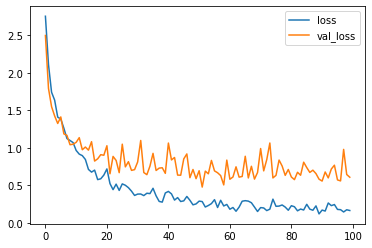

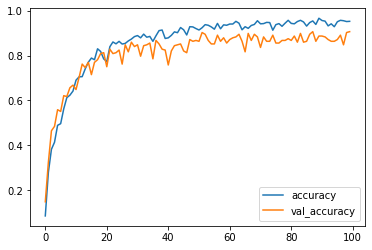

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();